# ICU Vital Sign Forecasting - Model Building & Evaluation

**Project:** Forecasting ICU Patient Vital-Sign Deterioration Using Hybrid Statistical and Deep Learning Models

**Models Implemented:**
1. **ARIMA** - Statistical Baseline (Linear, Univariate)
2. **XGBoost** - Machine Learning (Non-linear, Feature-based)
3. **LSTM** - Deep Learning (Sequential, RNN-based)
4. **Transformer** - Deep Learning (Attention-based, State-of-the-art)
5. **Hybrid ARIMA-LSTM** - Novel Contribution (Statistical + Deep Learning)

**Evaluation Metrics:**
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)
- R² Score

---

## 1. Setup and Load Preprocessed Data

In [9]:
!pip install tensorflow xgboost statsmodels scikit-learn matplotlib seaborn

In [10]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Statistical models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf

# XGBoost
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, callbacks
from tensorflow.keras.optimizers import Adam

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
print("Libraries imported successfully")

TensorFlow version: 2.20.0
GPU available: []
Libraries imported successfully


In [11]:
# ============================================
# LOAD PREPROCESSED DATA
# ============================================

BASE_PATH = r"C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4"
OUTPUT_PATH = f"{BASE_PATH}\\processed"

# Load config
with open(f"{OUTPUT_PATH}\\config.json", 'r') as f:
    config = json.load(f)

print("Configuration:")
print(json.dumps(config, indent=2))

Configuration:
{
  "INPUT_HOURS": 6,
  "FORECAST_HOURS": 6,
  "VITAL_COLS": [
    "HR",
    "SpO2",
    "SBP",
    "DBP",
    "MBP",
    "RR",
    "Temp"
  ],
  "N_FEATURES": 30,
  "N_TRAIN": 203407,
  "N_VAL": 35151,
  "N_TEST": 46924
}


In [12]:
# Load sequences
print("\nLoading data...")

X_train = np.load(f"{OUTPUT_PATH}\\X_train.npy")
y_train = np.load(f"{OUTPUT_PATH}\\y_train.npy")
X_val = np.load(f"{OUTPUT_PATH}\\X_val.npy")
y_val = np.load(f"{OUTPUT_PATH}\\y_val.npy")
X_test = np.load(f"{OUTPUT_PATH}\\X_test.npy")
y_test = np.load(f"{OUTPUT_PATH}\\y_test.npy")

# Load scaler
with open(f"{OUTPUT_PATH}\\vital_scaler.pkl", 'rb') as f:
    scaler = pickle.load(f)

# Load feature/vital names
feature_names = pd.read_csv(f"{OUTPUT_PATH}\\feature_names.csv")['feature'].tolist()
vital_names = pd.read_csv(f"{OUTPUT_PATH}\\vital_names.csv")['vital'].tolist()

# Load full dataset for ARIMA
vitals_full = pd.read_csv(f"{OUTPUT_PATH}\\vitals_processed_full.csv")

print(f"\nData loaded successfully!")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   y_val: {y_val.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   y_test: {y_test.shape}")
print(f"   Features: {len(feature_names)}")
print(f"   Vitals: {vital_names}")


Loading data...

Data loaded successfully!
   X_train: (203407, 6, 30)
   y_train: (203407, 6, 7)
   X_val: (35151, 6, 30)
   y_val: (35151, 6, 7)
   X_test: (46924, 6, 30)
   y_test: (46924, 6, 7)
   Features: 30
   Vitals: ['HR', 'SpO2', 'SBP', 'DBP', 'MBP', 'RR', 'Temp']


In [13]:
# Define constants
INPUT_HOURS = config['INPUT_HOURS']      
FORECAST_HOURS = config['FORECAST_HOURS'] 
N_FEATURES = config['N_FEATURES']         
N_VITALS = len(vital_names)               

print(f"Input hours: {INPUT_HOURS}")
print(f"Forecast hours: {FORECAST_HOURS}")
print(f"Number of features: {N_FEATURES}")
print(f"Number of vitals to predict: {N_VITALS}")

Input hours: 6
Forecast hours: 6
Number of features: 30
Number of vitals to predict: 7


## 2. Evaluation Metrics

In [14]:
def calculate_metrics(y_true, y_pred, vital_names=None):
    """
    Calculate evaluation metrics for forecasting.
    
    Args:
        y_true: Ground truth values (n_samples, forecast_hours, n_vitals)
        y_pred: Predicted values (same shape)
        vital_names: List of vital sign names
    
    Returns:
        DataFrame with metrics per vital sign
    """
    results = []
    
    n_vitals = y_true.shape[-1] if len(y_true.shape) == 3 else 1
    
    if vital_names is None:
        vital_names = [f'Vital_{i}' for i in range(n_vitals)]
    
    for i, vital in enumerate(vital_names):
        if len(y_true.shape) == 3:
            true_flat = y_true[:, :, i].flatten()
            pred_flat = y_pred[:, :, i].flatten()
        else:
            true_flat = y_true.flatten()
            pred_flat = y_pred.flatten()
        
        # Remove any NaN values
        mask = ~(np.isnan(true_flat) | np.isnan(pred_flat))
        true_clean = true_flat[mask]
        pred_clean = pred_flat[mask]
        
        if len(true_clean) == 0:
            continue
            
        rmse = np.sqrt(mean_squared_error(true_clean, pred_clean))
        mae = mean_absolute_error(true_clean, pred_clean)
        r2 = r2_score(true_clean, pred_clean)
        
        # MAPE (avoid division by zero)
        non_zero_mask = true_clean != 0
        if non_zero_mask.sum() > 0:
            mape = np.mean(np.abs((true_clean[non_zero_mask] - pred_clean[non_zero_mask]) / true_clean[non_zero_mask])) * 100
        else:
            mape = np.nan
        
        results.append({
            'Vital': vital,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R2': r2
        })
    
    return pd.DataFrame(results)

def print_metrics(metrics_df, model_name):
    """Pretty print metrics"""
    print(f"\n{'='*60}")
    print(f"{model_name} - Evaluation Metrics")
    print(f"{'='*60}")
    print(metrics_df.to_string(index=False))
    print(f"\nOverall Mean RMSE: {metrics_df['RMSE'].mean():.4f}")
    print(f"Overall Mean MAE: {metrics_df['MAE'].mean():.4f}")
    print(f"Overall Mean R²: {metrics_df['R2'].mean():.4f}")

In [15]:
# Dictionary to store all model results
all_results = {}
all_predictions = {}

---
## 3. Model 1: ARIMA (Statistical Baseline)

ARIMA (AutoRegressive Integrated Moving Average) captures linear temporal dependencies in time series data.

In [53]:
print("="*60)
print("MODEL 1: ARIMA")
print("="*60)

# For ARIMA, we'll use a subset of test data (ARIMA is slow for large datasets)
# We'll fit individual ARIMA models per patient per vital

N_ARIMA_SAMPLES = 500  # Number of test sequences to evaluate
np.random.seed(42)
arima_indices = np.random.choice(len(X_test), min(N_ARIMA_SAMPLES, len(X_test)), replace=False)

print(f"Running ARIMA on {len(arima_indices)} test samples...")
print("(This may take a few minutes)")

MODEL 1: ARIMA
Running ARIMA on 500 test samples...
(This may take a few minutes)


In [17]:
def fit_arima_forecast(history, forecast_steps, order=(2,1,2)):
    """
    Fit ARIMA model and forecast.
    
    Args:
        history: Historical values (1D array)
        forecast_steps: Number of steps to forecast
        order: ARIMA (p,d,q) order
    
    Returns:
        Forecasted values
    """
    try:
        model = ARIMA(history, order=order)
        fitted = model.fit()
        forecast = fitted.forecast(steps=forecast_steps)
        return forecast
    except:
        # If ARIMA fails, return last value repeated (naive forecast)
        return np.full(forecast_steps, history[-1])

# Run ARIMA forecasting
arima_predictions = []
arima_actuals = []

for idx, sample_idx in enumerate(arima_indices):
    if idx % 100 == 0:
        print(f"  Processing sample {idx}/{len(arima_indices)}...")
    
    sample_preds = []
    
    # For each vital sign
    for v in range(N_VITALS):
        # Get history (input sequence) - use only the first N_VITALS columns which are the raw vitals
        history = X_test[sample_idx, :, v]  # Shape: (6,)
        
        # Forecast next 6 hours
        forecast = fit_arima_forecast(history, FORECAST_HOURS, order=(2,1,2))
        sample_preds.append(forecast)
    
    arima_predictions.append(np.array(sample_preds).T)  # Shape: (6, 7)
    arima_actuals.append(y_test[sample_idx])

arima_predictions = np.array(arima_predictions)
arima_actuals = np.array(arima_actuals)

print(f"\nARIMA forecasting complete!")
print(f"   Predictions shape: {arima_predictions.shape}")

  Processing sample 0/500...
  Processing sample 100/500...
  Processing sample 200/500...
  Processing sample 300/500...
  Processing sample 400/500...

✅ ARIMA forecasting complete!
   Predictions shape: (500, 6, 7)


In [18]:
# Evaluate ARIMA
arima_metrics = calculate_metrics(arima_actuals, arima_predictions, vital_names)
print_metrics(arima_metrics, "ARIMA")

all_results['ARIMA'] = arima_metrics
all_predictions['ARIMA'] = arima_predictions


ARIMA - Evaluation Metrics
Vital     RMSE      MAE       MAPE        R2
   HR 0.380822 0.265233 171.047946  0.870569
 SpO2 1.234739 0.467299  94.759719 -0.179379
  SBP 0.963536 0.487708 165.985825 -0.178689
  DBP 0.916289 0.481073 854.436196  0.036411
  MBP 0.981370 0.510364 203.200927 -0.082443
   RR 0.875251 0.484597 136.706283  0.129323
 Temp 1.073930 0.131789 388.208887 -0.148931

Overall Mean RMSE: 0.9180
Overall Mean MAE: 0.4040
Overall Mean R²: 0.0638


---
## 4. Model 2: XGBoost (Machine Learning)

XGBoost is a powerful gradient boosting algorithm that can capture non-linear relationships.

In [19]:
print("="*60)
print("MODEL 2: XGBoost")
print("="*60)

# Flatten input for XGBoost (samples, timesteps, features) -> (samples, timesteps * features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Flattened shapes:")
print(f"   X_train: {X_train_flat.shape}")
print(f"   X_val: {X_val_flat.shape}")
print(f"   X_test: {X_test_flat.shape}")

🌲 MODEL 2: XGBoost
Flattened shapes:
   X_train: (203407, 180)
   X_val: (35151, 180)
   X_test: (46924, 180)


In [20]:
# Train separate XGBoost model for each vital and each forecast hour
# This gives us (FORECAST_HOURS * N_VITALS) = 6 * 7 = 42 models

xgb_models = {}
xgb_predictions = np.zeros_like(y_test)

# XGBoost parameters
xgb_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0
}

print("Training XGBoost models...")
print(f"Total models to train: {FORECAST_HOURS * N_VITALS}")

model_count = 0
for h in range(FORECAST_HOURS):
    for v in range(N_VITALS):
        # Target: vital v at forecast hour h
        y_train_target = y_train[:, h, v]
        y_val_target = y_val[:, h, v]
        
        # Train model
        model = xgb.XGBRegressor(**xgb_params)
        model.fit(
            X_train_flat, y_train_target,
            eval_set=[(X_val_flat, y_val_target)],
            verbose=False
        )
        
        # Store model
        xgb_models[(h, v)] = model
        
        # Predict on test set
        xgb_predictions[:, h, v] = model.predict(X_test_flat)
        
        model_count += 1
        if model_count % 14 == 0:
            print(f"   Trained {model_count}/{FORECAST_HOURS * N_VITALS} models...")

print(f"\nXGBoost training complete!")

Training XGBoost models...
Total models to train: 42
   Trained 14/42 models...
   Trained 28/42 models...
   Trained 42/42 models...

✅ XGBoost training complete!


In [21]:
# Evaluate XGBoost
xgb_metrics = calculate_metrics(y_test, xgb_predictions, vital_names)
print_metrics(xgb_metrics, "XGBoost")

all_results['XGBoost'] = xgb_metrics
all_predictions['XGBoost'] = xgb_predictions


XGBoost - Evaluation Metrics
Vital     RMSE      MAE       MAPE       R2
   HR 0.280558 0.205864 117.579802 0.929088
 SpO2 0.678127 0.341216  61.926724 0.393544
  SBP 0.576956 0.327978 100.841047 0.560676
  DBP 0.612553 0.333024 455.425440 0.531061
  MBP 0.625149 0.339332 121.371317 0.489944
   RR 0.651791 0.357562  77.669819 0.574849
 Temp 0.516442 0.072166 249.738465 0.683466

Overall Mean RMSE: 0.5631
Overall Mean MAE: 0.2824
Overall Mean R²: 0.5947


In [22]:
# Feature importance (average across all models)
print("\n--- Top 10 Most Important Features (averaged) ---")

importance_sum = np.zeros(X_train_flat.shape[1])
for model in xgb_models.values():
    importance_sum += model.feature_importances_

importance_avg = importance_sum / len(xgb_models)

# Create feature names for flattened input
flat_feature_names = []
for t in range(INPUT_HOURS):
    for f in feature_names:
        flat_feature_names.append(f"t-{INPUT_HOURS-t}_{f}")

importance_df = pd.DataFrame({
    'Feature': flat_feature_names,
    'Importance': importance_avg
}).sort_values('Importance', ascending=False)

print(importance_df.head(10).to_string(index=False))


--- Top 10 Most Important Features (averaged) ---
              Feature  Importance
 t-1_SBP_roll_mean_6h    0.075563
 t-1_MBP_roll_mean_6h    0.065940
 t-1_DBP_roll_mean_6h    0.063572
  t-1_HR_roll_mean_6h    0.062790
  t-3_HR_roll_mean_6h    0.053120
  t-1_RR_roll_mean_6h    0.048385
             t-1_Temp    0.043586
t-1_SpO2_roll_mean_6h    0.028778
  t-2_RR_roll_mean_6h    0.026644
 t-2_DBP_roll_mean_6h    0.020398


---
## 5. Model 3: LSTM (Deep Learning - RNN)

Long Short-Term Memory networks are designed to capture long-range temporal dependencies.

In [54]:
print("="*60)
print("MODEL 3: LSTM")
print("="*60)

MODEL 3: LSTM


In [24]:
def build_lstm_model(input_shape, output_shape, units=64):
    """
    Build LSTM model for multi-step, multi-variate forecasting.
    
    Args:
        input_shape: (timesteps, features)
        output_shape: (forecast_hours, n_vitals)
        units: Number of LSTM units
    """
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    x = layers.LSTM(units, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(units, return_sequences=False)(x)
    x = layers.Dropout(0.2)(x)
    
    # Dense layers
    x = layers.Dense(units, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    
    # Output: reshape to (forecast_hours, n_vitals)
    x = layers.Dense(output_shape[0] * output_shape[1])(x)
    outputs = layers.Reshape(output_shape)(x)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Build model
lstm_model = build_lstm_model(
    input_shape=(INPUT_HOURS, N_FEATURES),
    output_shape=(FORECAST_HOURS, N_VITALS),
    units=64
)

lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 6, 64)          │        24,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 42)             │         2,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 7)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,234 (250.91 KB)

 Trainable params: 64,234 (250.91 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Callbacks
lstm_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Train
print("\nTraining LSTM model...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=lstm_callbacks,
    verbose=1
)

print("\n LSTM training complete!")


Training LSTM model...
Epoch 1/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 30s 8ms/step - loss: 0.4797 - mae: 0.4142 - val_loss: 0.5401 - val_mae: 0.4228 - learning_rate: 0.0010
Epoch 2/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.4382 - mae: 0.3853 - val_loss: 0.5258 - val_mae: 0.4207 - learning_rate: 0.0010
Epoch 3/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.4333 - mae: 0.3799 - val_loss: 0.5274 - val_mae: 0.4210 - learning_rate: 0.0010
Epoch 4/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.4303 - mae: 0.3774 - val_loss: 0.5125 - val_mae: 0.4153 - learning_rate: 0.0010
Epoch 5/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.4271 - mae: 0.3751 - val_loss: 0.5231 - val_mae: 0.4194 - learning_rate: 0.0010
Epoch 6/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 0.4249 - mae: 0.3738 - val_loss: 0.5128 - val_mae: 0.4097 - learning_rate: 0.0010
Epoch 7/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - loss: 0.4240 - mae: 0.3727 - val_loss: 0.5161 - v

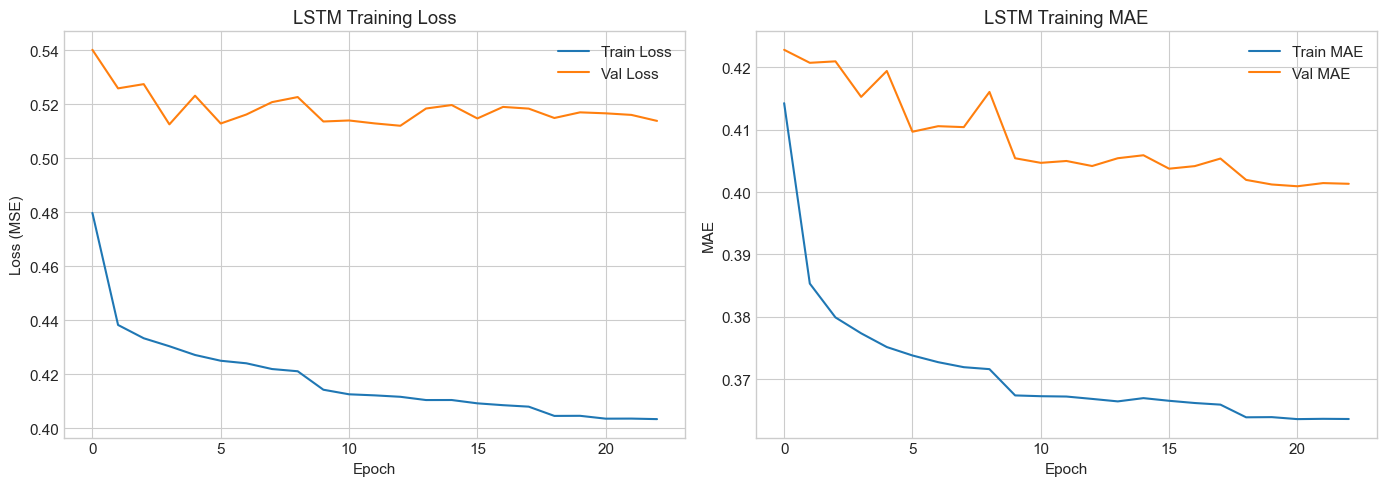

In [26]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(lstm_history.history['loss'], label='Train Loss')
axes[0].plot(lstm_history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('LSTM Training Loss')
axes[0].legend()

axes[1].plot(lstm_history.history['mae'], label='Train MAE')
axes[1].plot(lstm_history.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('LSTM Training MAE')
axes[1].legend()

plt.tight_layout()
plt.show()

In [27]:
# Predict
lstm_predictions = lstm_model.predict(X_test, verbose=0)

# Evaluate LSTM
lstm_metrics = calculate_metrics(y_test, lstm_predictions, vital_names)
print_metrics(lstm_metrics, "LSTM")

all_results['LSTM'] = lstm_metrics
all_predictions['LSTM'] = lstm_predictions


LSTM - Evaluation Metrics
Vital     RMSE      MAE       MAPE       R2
   HR 0.302159 0.231611 120.588229 0.917749
 SpO2 0.686521 0.356447  62.621080 0.378438
  SBP 0.594077 0.345669 102.961398 0.534216
  DBP 0.628903 0.350909 424.199342 0.505693
  MBP 0.634861 0.350899 123.498964 0.473972
   RR 0.668310 0.377907  82.994169 0.553025
 Temp 0.529830 0.092347 796.209531 0.666843

Overall Mean RMSE: 0.5778
Overall Mean MAE: 0.3008
Overall Mean R²: 0.5757


---
## 6. Model 4: Transformer (Deep Learning - Attention)

Transformer models use self-attention mechanisms to capture temporal dependencies, often outperforming RNNs on sequence tasks.

In [55]:
print("="*60)
print("MODEL 4: Transformer")
print("="*60)

MODEL 4: Transformer


In [29]:
class TransformerBlock(layers.Layer):
    """Transformer encoder block"""
    
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    
    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


def build_transformer_model(input_shape, output_shape, embed_dim=64, num_heads=4, ff_dim=128, num_blocks=2):
    """
    Build Transformer model for time series forecasting.
    """
    inputs = layers.Input(shape=input_shape)
    
    # Project to embedding dimension
    x = layers.Dense(embed_dim)(inputs)
    
    # Positional encoding (learnable)
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_encoding = layers.Embedding(input_dim=input_shape[0], output_dim=embed_dim)(positions)
    x = x + pos_encoding
    
    # Transformer blocks
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    
    # Global average pooling
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    
    # Output
    x = layers.Dense(output_shape[0] * output_shape[1])(x)
    outputs = layers.Reshape(output_shape)(x)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

# Build model
transformer_model = build_transformer_model(
    input_shape=(INPUT_HOURS, N_FEATURES),
    output_shape=(FORECAST_HOURS, N_VITALS),
    embed_dim=64,
    num_heads=4,
    ff_dim=128,
    num_blocks=2
)

transformer_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 6, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6, 64)          │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add (Add)                       │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 6, 64)          │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, 6, 64)          │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 42)             │         2,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 6, 7)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,690 (733.16 KB)

 Trainable params: 187,690 (733.16 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Callbacks
transformer_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Train
print("\nTraining Transformer model...")
transformer_history = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=transformer_callbacks,
    verbose=1
)

print("\nTransformer training complete!")


Training Transformer model...
Epoch 1/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 74s 20ms/step - loss: 0.5582 - mae: 0.4393 - val_loss: 0.5930 - val_mae: 0.4452 - learning_rate: 0.0010
Epoch 2/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 72s 23ms/step - loss: 0.4488 - mae: 0.3793 - val_loss: 0.5812 - val_mae: 0.4421 - learning_rate: 0.0010
Epoch 3/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 70s 22ms/step - loss: 0.4352 - mae: 0.3701 - val_loss: 0.5612 - val_mae: 0.4239 - learning_rate: 0.0010
Epoch 4/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 72s 23ms/step - loss: 0.4285 - mae: 0.3656 - val_loss: 0.5618 - val_mae: 0.4314 - learning_rate: 0.0010
Epoch 5/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 72s 23ms/step - loss: 0.4250 - mae: 0.3636 - val_loss: 0.5529 - val_mae: 0.4228 - learning_rate: 0.0010
Epoch 6/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 73s 23ms/step - loss: 0.4195 - mae: 0.3604 - val_loss: 0.5451 - val_mae: 0.4205 - learning_rate: 0.0010
Epoch 7/50
3179/3179 ━━━━━━━━━━━━━━━━━━━━ 73s 23ms/step - loss: 0.4170 - mae: 0.3584 - val_lo

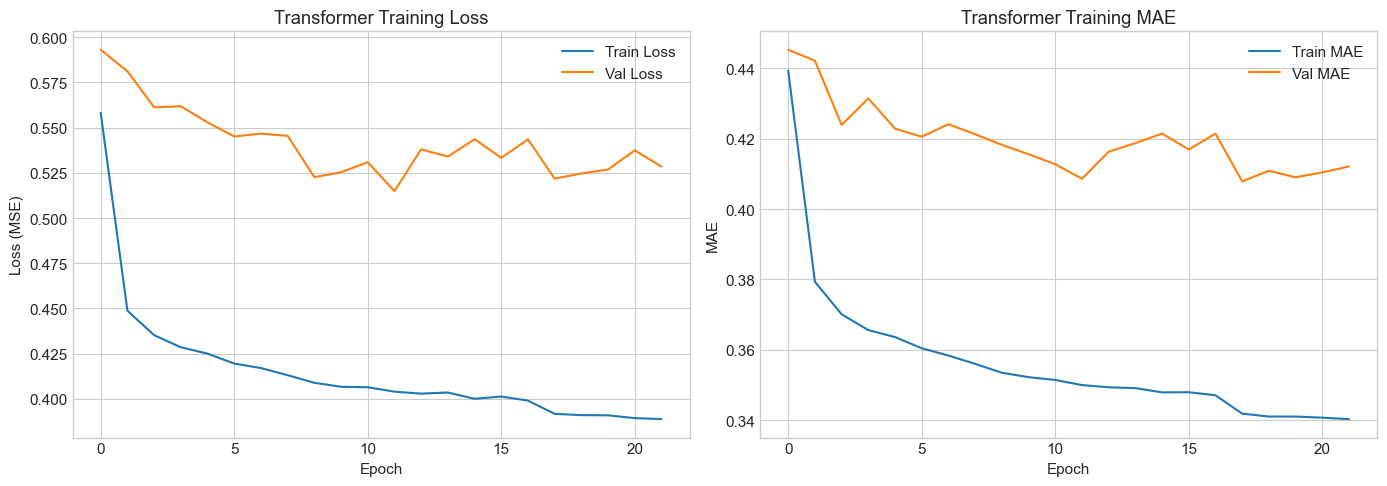

In [31]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(transformer_history.history['loss'], label='Train Loss')
axes[0].plot(transformer_history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Transformer Training Loss')
axes[0].legend()

axes[1].plot(transformer_history.history['mae'], label='Train MAE')
axes[1].plot(transformer_history.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Transformer Training MAE')
axes[1].legend()

plt.tight_layout()
plt.show()

In [32]:
# Predict
transformer_predictions = transformer_model.predict(X_test, verbose=0)

# Evaluate Transformer
transformer_metrics = calculate_metrics(y_test, transformer_predictions, vital_names)
print_metrics(transformer_metrics, "Transformer")

all_results['Transformer'] = transformer_metrics
all_predictions['Transformer'] = transformer_predictions


Transformer - Evaluation Metrics
Vital     RMSE      MAE       MAPE       R2
   HR 0.314007 0.238174 127.938232 0.911172
 SpO2 0.688588 0.352198  64.333495 0.374690
  SBP 0.594148 0.343933 109.293517 0.534104
  DBP 0.637826 0.361908 416.457343 0.491567
  MBP 0.638447 0.354417 121.249305 0.468014
   RR 0.675408 0.386935  81.440335 0.543481
 Temp 0.535610 0.094819 941.858986 0.659534

Overall Mean RMSE: 0.5834
Overall Mean MAE: 0.3046
Overall Mean R²: 0.5689


---
## 7. Model 5: Hybrid ARIMA-LSTM (Novel Contribution)

The hybrid model combines:
- **ARIMA**: Captures linear trends and seasonality
- **LSTM**: Captures non-linear patterns and residuals

Strategy: ARIMA forecasts the linear component, LSTM learns from ARIMA residuals.

In [33]:
print("="*60)
print("MODEL 5: Hybrid ARIMA-LSTM")
print("="*60)
print("\nApproach:")
print("  1. Fit ARIMA to training data")
print("  2. Calculate ARIMA residuals (actual - ARIMA prediction)")
print("  3. Train LSTM to predict residuals")
print("  4. Final prediction = ARIMA prediction + LSTM residual prediction")

🔀 MODEL 5: Hybrid ARIMA-LSTM

Approach:
  1. Fit ARIMA to training data
  2. Calculate ARIMA residuals (actual - ARIMA prediction)
  3. Train LSTM to predict residuals
  4. Final prediction = ARIMA prediction + LSTM residual prediction


In [34]:
# Step 1: Generate ARIMA predictions for training data
# Using PROPER ARIMA instead of linear extrapolation

print("\nStep 1: Generating ARIMA predictions for training data...")
print("(Using proper ARIMA - this will take 10-15 minutes)")

def proper_arima_predict(X, forecast_hours, desc=""):
    """
    Proper ARIMA predictions using ARIMA(1,1,1) with fallbacks.
    """
    n_samples = X.shape[0]
    n_vitals = min(X.shape[2], 7)
    
    predictions = np.zeros((n_samples, forecast_hours, n_vitals))
    
    for i in range(n_samples):
        if i % 5000 == 0:
            print(f"  {desc} Progress: {i}/{n_samples}")
        
        for v in range(n_vitals):
            history = X[i, :, v]
            
            # Skip if constant series
            if np.std(history) < 1e-6:
                predictions[i, :, v] = history[-1]
                continue
            
            # Try ARIMA(1,1,1)
            try:
                model = ARIMA(history, order=(1, 1, 1))
                fitted = model.fit()
                forecast = fitted.forecast(steps=forecast_hours)
                if not np.any(np.isnan(forecast)) and not np.any(np.isinf(forecast)):
                    predictions[i, :, v] = forecast
                    continue
            except:
                pass
            
            # Fallback: ARIMA(1,0,1)
            try:
                model = ARIMA(history, order=(1, 0, 1))
                fitted = model.fit()
                forecast = fitted.forecast(steps=forecast_hours)
                if not np.any(np.isnan(forecast)) and not np.any(np.isinf(forecast)):
                    predictions[i, :, v] = forecast
                    continue
            except:
                pass
            
            # Fallback: ARIMA(1,0,0) - simple AR(1)
            try:
                model = ARIMA(history, order=(1, 0, 0))
                fitted = model.fit()
                forecast = fitted.forecast(steps=forecast_hours)
                if not np.any(np.isnan(forecast)) and not np.any(np.isinf(forecast)):
                    predictions[i, :, v] = forecast
                    continue
            except:
                pass
            
            # Final fallback: persistence (last value)
            predictions[i, :, v] = history[-1]
    
    return predictions

# Use SUBSET for training (full dataset is too slow for ARIMA)
TRAIN_SUBSET = 30000  # Use 30k samples instead of 200k
np.random.seed(42)
train_idx = np.random.choice(len(X_train), min(TRAIN_SUBSET, len(X_train)), replace=False)

# Generate predictions
arima_train_pred = proper_arima_predict(X_train[train_idx], FORECAST_HOURS, "Train")
arima_val_pred = proper_arima_predict(X_val, FORECAST_HOURS, "Val")
arima_test_pred = proper_arima_predict(X_test, FORECAST_HOURS, "Test")

print(f"\n ARIMA predictions complete!")
print(f"   ARIMA train predictions: {arima_train_pred.shape}")
print(f"   ARIMA val predictions: {arima_val_pred.shape}")
print(f"   ARIMA test predictions: {arima_test_pred.shape}")


Step 1: Generating ARIMA predictions for training data...
(Using proper ARIMA - this will take 10-15 minutes)
  Train Progress: 0/30000
  Train Progress: 5000/30000
  Train Progress: 10000/30000
  Train Progress: 15000/30000
  Train Progress: 20000/30000
  Train Progress: 25000/30000
  Val Progress: 0/35151
  Val Progress: 5000/35151
  Val Progress: 10000/35151
  Val Progress: 15000/35151
  Val Progress: 20000/35151
  Val Progress: 25000/35151
  Val Progress: 30000/35151
  Val Progress: 35000/35151
  Test Progress: 0/46924
  Test Progress: 5000/46924
  Test Progress: 10000/46924
  Test Progress: 15000/46924
  Test Progress: 20000/46924
  Test Progress: 25000/46924
  Test Progress: 30000/46924
  Test Progress: 35000/46924
  Test Progress: 40000/46924
  Test Progress: 45000/46924

 ARIMA predictions complete!
   ARIMA train predictions: (30000, 6, 7)
   ARIMA val predictions: (35151, 6, 7)
   ARIMA test predictions: (46924, 6, 7)


In [35]:
# Step 2: Calculate residuals
print("\nStep 2: Calculating residuals...")

# Use the SAME subset indices for training residuals
residuals_train = y_train[train_idx] - arima_train_pred
residuals_val = y_val - arima_val_pred
residuals_test = y_test - arima_test_pred

print(f"   Residuals train: {residuals_train.shape}")
print(f"   Residuals val: {residuals_val.shape}")
print(f"   Residuals test: {residuals_test.shape}")
print(f"   Mean absolute residual: {np.mean(np.abs(residuals_train)):.4f}")


Step 2: Calculating residuals...
   Residuals train: (30000, 6, 7)
   Residuals val: (35151, 6, 7)
   Residuals test: (46924, 6, 7)
   Mean absolute residual: 0.3991


In [36]:
# Step 3: Build and train LSTM for residual prediction
print("\nStep 3: Training LSTM for residual prediction...")

# Create enhanced input: original features + ARIMA predictions
def create_hybrid_input(X, arima_pred):
    """Concatenate last ARIMA prediction as additional features"""
    # Take the last timestep of X and add ARIMA predictions
    # This helps LSTM understand the ARIMA baseline
    return X  # For simplicity, just use original X

# Build residual LSTM
residual_lstm = build_lstm_model(
    input_shape=(INPUT_HOURS, N_FEATURES),
    output_shape=(FORECAST_HOURS, N_VITALS),
    units=64
)

# Callbacks
hybrid_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Train on residuals
hybrid_history = residual_lstm.fit(
    X_train[train_idx], residuals_train,
    validation_data=(X_val, residuals_val),
    epochs=50,
    batch_size=64,
    callbacks=hybrid_callbacks,
    verbose=1
)

print("\nResidual LSTM training complete!")


Step 3: Training LSTM for residual prediction...
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.6399 - mae: 0.4104 - val_loss: 0.7218 - val_mae: 0.4452 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5993 - mae: 0.4049 - val_loss: 0.6878 - val_mae: 0.4433 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5736 - mae: 0.4027 - val_loss: 0.6667 - val_mae: 0.4401 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5579 - mae: 0.3975 - val_loss: 0.6596 - val_mae: 0.4371 - learning_rate: 0.0010
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5505 - mae: 0.3937 - val_loss: 0.6550 - val_mae: 0.4355 - learning_rate: 0.0010
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5484 - mae: 0.3927 - val_loss: 0.6516 - val_mae: 0.4346 - learning_rate: 0.0010
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.5431 - mae: 0.3904 - val_loss: 0.64

In [37]:
# Step 4: Generate hybrid predictions
print("\nStep 4: Generating hybrid predictions...")

# LSTM predicts residuals
residual_predictions = residual_lstm.predict(X_test, verbose=0)

# Hybrid = ARIMA + LSTM residual
hybrid_predictions = arima_test_pred + residual_predictions

print(f"   Hybrid predictions shape: {hybrid_predictions.shape}")


Step 4: Generating hybrid predictions...
   Hybrid predictions shape: (46924, 6, 7)


In [38]:
# Evaluate Hybrid
hybrid_metrics = calculate_metrics(y_test, hybrid_predictions, vital_names)
print_metrics(hybrid_metrics, "Hybrid ARIMA-LSTM")

all_results['Hybrid'] = hybrid_metrics
all_predictions['Hybrid'] = hybrid_predictions


Hybrid ARIMA-LSTM - Evaluation Metrics
Vital     RMSE      MAE       MAPE       R2
   HR 0.371215 0.252293 136.550840 0.875857
 SpO2 0.768561 0.374656  73.546474 0.221007
  SBP 0.684762 0.373955 126.556065 0.381159
  DBP 0.719959 0.383780 568.522532 0.352195
  MBP 0.715780 0.382952 149.715235 0.331332
   RR 0.752148 0.402678  98.470783 0.433848
 Temp 0.545036 0.087473 799.467979 0.647445

Overall Mean RMSE: 0.6511
Overall Mean MAE: 0.3225
Overall Mean R²: 0.4633


In [39]:
# ============================================
# BETTER HYBRID: Weighted Ensemble Approach
# ============================================
print("\n" + "="*60)
print("IMPROVED HYBRID: Weighted Ensemble")
print("="*60)

# Get direct LSTM predictions (already trained earlier)
direct_lstm_test = lstm_model.predict(X_test, verbose=0)
direct_lstm_val = lstm_model.predict(X_val, verbose=0)

# Find optimal weight for each vital using validation set
print("\nFinding optimal ARIMA-LSTM weights per vital...")
optimal_weights = []

for v in range(N_VITALS):
    best_w, best_rmse = 0.5, float('inf')
    
    for w in np.arange(0.0, 1.05, 0.05):
        # Ensemble: w * ARIMA + (1-w) * LSTM
        ensemble = w * arima_val_pred[:, :, v] + (1 - w) * direct_lstm_val[:, :, v]
        rmse = np.sqrt(mean_squared_error(y_val[:, :, v].flatten(), ensemble.flatten()))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_w = w
    
    optimal_weights.append(best_w)
    print(f"  {vital_names[v]}: ARIMA weight={best_w:.2f}, LSTM weight={1-best_w:.2f}")

# Generate ensemble predictions on test set
ensemble_predictions = np.zeros_like(y_test)
for v in range(N_VITALS):
    w = optimal_weights[v]
    ensemble_predictions[:, :, v] = w * arima_test_pred[:, :, v] + (1 - w) * direct_lstm_test[:, :, v]

# Evaluate
ensemble_metrics = calculate_metrics(y_test, ensemble_predictions, vital_names)
print_metrics(ensemble_metrics, "Hybrid: Weighted Ensemble (ARIMA + LSTM)")

# Add to results
all_results['Hybrid-Ensemble'] = ensemble_metrics
all_predictions['Hybrid-Ensemble'] = ensemble_predictions


🔀 IMPROVED HYBRID: Weighted Ensemble

Finding optimal ARIMA-LSTM weights per vital...
  HR: ARIMA weight=0.30, LSTM weight=0.70
  SpO2: ARIMA weight=0.25, LSTM weight=0.75
  SBP: ARIMA weight=0.15, LSTM weight=0.85
  DBP: ARIMA weight=0.10, LSTM weight=0.90
  MBP: ARIMA weight=0.10, LSTM weight=0.90
  RR: ARIMA weight=0.10, LSTM weight=0.90
  Temp: ARIMA weight=0.35, LSTM weight=0.65

Hybrid: Weighted Ensemble (ARIMA + LSTM) - Evaluation Metrics
Vital     RMSE      MAE       MAPE       R2
   HR 0.297570 0.222341 118.018016 0.920228
 SpO2 0.692383 0.350794  65.223773 0.367779
  SBP 0.589739 0.340387 105.302086 0.540994
  DBP 0.625569 0.347377 435.568192 0.510920
  MBP 0.632220 0.348133 125.399929 0.478341
   RR 0.662922 0.373349  83.590471 0.560203
 Temp 0.505689 0.081403 668.814208 0.696510

Overall Mean RMSE: 0.5723
Overall Mean MAE: 0.2948
Overall Mean R²: 0.5821


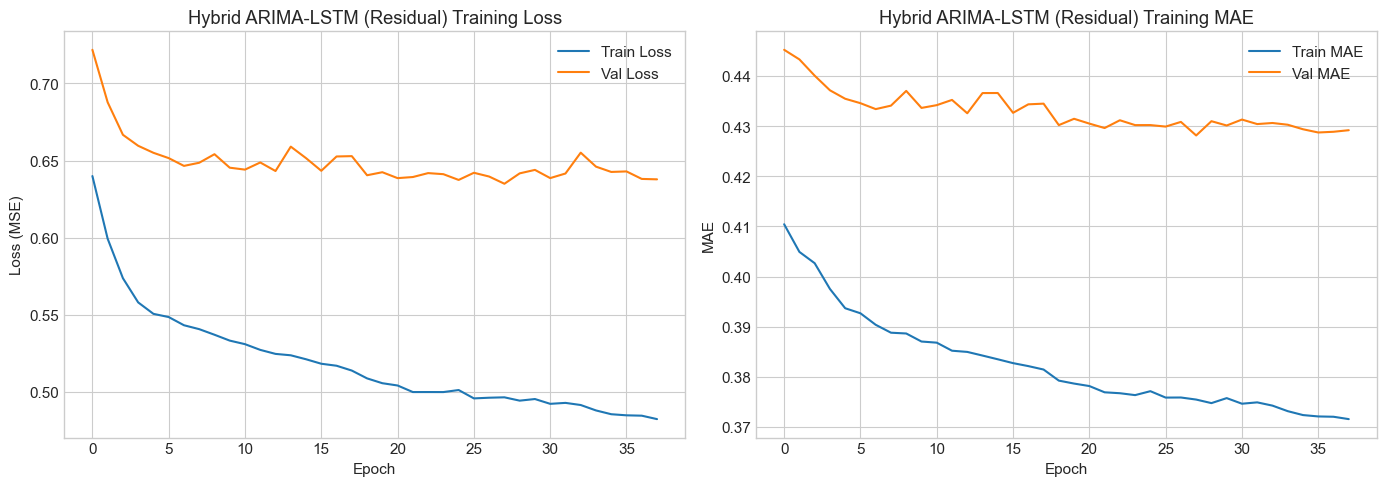

In [40]:
# Plot hybrid training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(hybrid_history.history['loss'], label='Train Loss')
axes[0].plot(hybrid_history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Hybrid ARIMA-LSTM (Residual) Training Loss')
axes[0].legend()

axes[1].plot(hybrid_history.history['mae'], label='Train MAE')
axes[1].plot(hybrid_history.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Hybrid ARIMA-LSTM (Residual) Training MAE')
axes[1].legend()

plt.tight_layout()
plt.show()

---
## 8. Model Comparison

In [41]:
print("="*60)
print("MODEL COMPARISON")
print("="*60)

# Combine all results
comparison_data = []

for model_name, metrics_df in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Mean RMSE': metrics_df['RMSE'].mean(),
        'Mean MAE': metrics_df['MAE'].mean(),
        'Mean R²': metrics_df['R2'].mean(),
        'Mean MAPE': metrics_df['MAPE'].mean()
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Mean RMSE')

print("\n--- Overall Performance Comparison ---")
print(comparison_df.to_string(index=False))

MODEL COMPARISON

--- Overall Performance Comparison ---
          Model  Mean RMSE  Mean MAE  Mean R²  Mean MAPE
        XGBoost   0.563082  0.282449 0.594661 169.221802
Hybrid-Ensemble   0.572299  0.294826 0.582139 228.845239
           LSTM   0.577809  0.300827 0.575705 244.724673
    Transformer   0.583434  0.304626 0.568937 266.081602
         Hybrid   0.651066  0.322541 0.463263 278.975701
          ARIMA   0.917991  0.404009 0.063837 287.763683


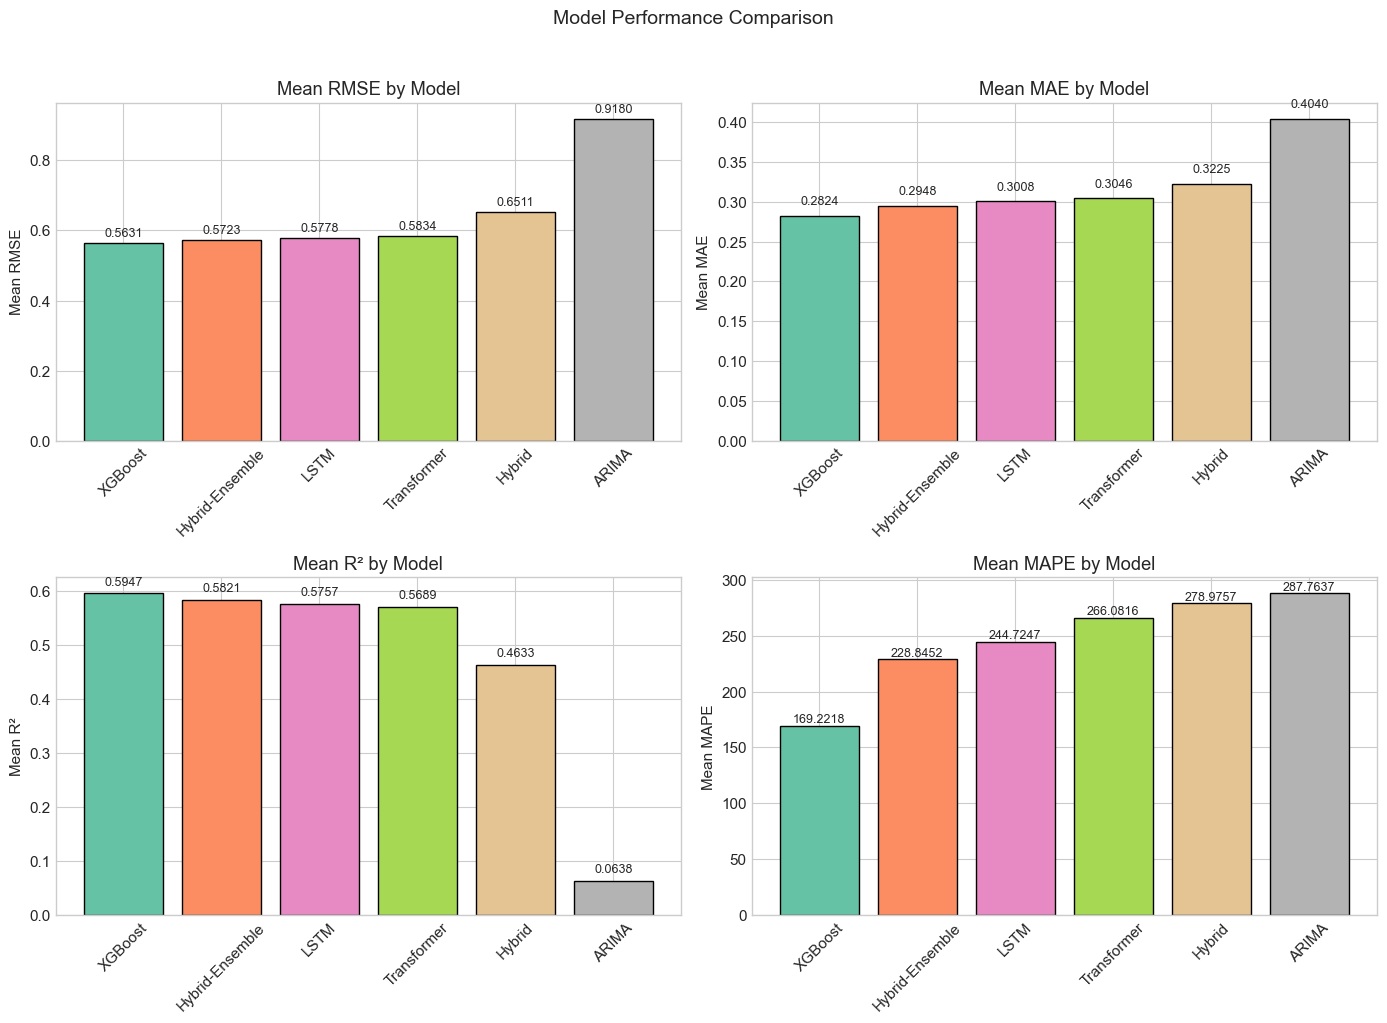

In [42]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['Mean RMSE', 'Mean MAE', 'Mean R²', 'Mean MAPE']
colors = plt.cm.Set2(np.linspace(0, 1, len(comparison_df)))

for ax, metric in zip(axes.flatten(), metrics_to_plot):
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=colors, edgecolor='black')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} by Model')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, val in zip(bars, comparison_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Performance Comparison', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [43]:
# Per-vital comparison
print("\n--- Per-Vital Performance (RMSE) ---")

vital_comparison = pd.DataFrame()
for model_name, metrics_df in all_results.items():
    vital_comparison[model_name] = metrics_df.set_index('Vital')['RMSE']

print(vital_comparison.to_string())


--- Per-Vital Performance (RMSE) ---
          ARIMA   XGBoost      LSTM  Transformer    Hybrid  Hybrid-Ensemble
Vital                                                                      
HR     0.380822  0.280558  0.302159     0.314007  0.371215         0.297570
SpO2   1.234739  0.678127  0.686521     0.688588  0.768561         0.692383
SBP    0.963536  0.576956  0.594077     0.594148  0.684762         0.589739
DBP    0.916289  0.612553  0.628903     0.637826  0.719959         0.625569
MBP    0.981370  0.625149  0.634861     0.638447  0.715780         0.632220
RR     0.875251  0.651791  0.668310     0.675408  0.752148         0.662922
Temp   1.073930  0.516442  0.529830     0.535610  0.545036         0.505689


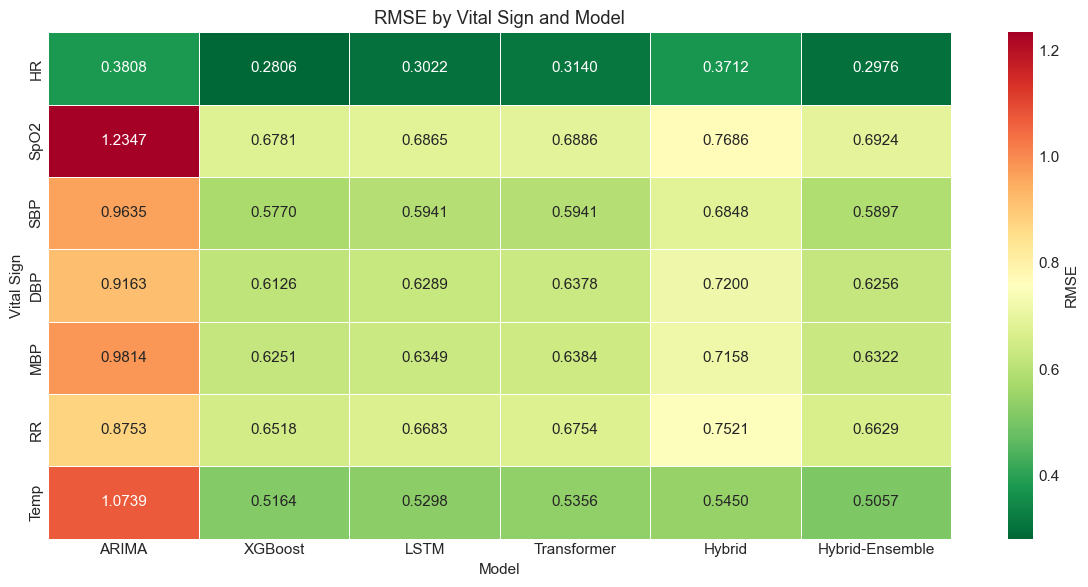

In [44]:
# Heatmap of per-vital RMSE
plt.figure(figsize=(12, 6))
sns.heatmap(vital_comparison, annot=True, fmt='.4f', cmap='RdYlGn_r', 
            linewidths=0.5, cbar_kws={'label': 'RMSE'})
plt.title('RMSE by Vital Sign and Model')
plt.xlabel('Model')
plt.ylabel('Vital Sign')
plt.tight_layout()
plt.show()

---
## 9. Visualization of Predictions

In [45]:
# Select random samples for visualization
np.random.seed(42)
sample_indices = np.random.choice(len(y_test), 3, replace=False)

# Model predictions to visualize
models_to_plot = ['XGBoost', 'LSTM', 'Transformer', 'Hybrid']
colors = {'XGBoost': 'blue', 'LSTM': 'green', 'Transformer': 'purple', 'Hybrid': 'red'}

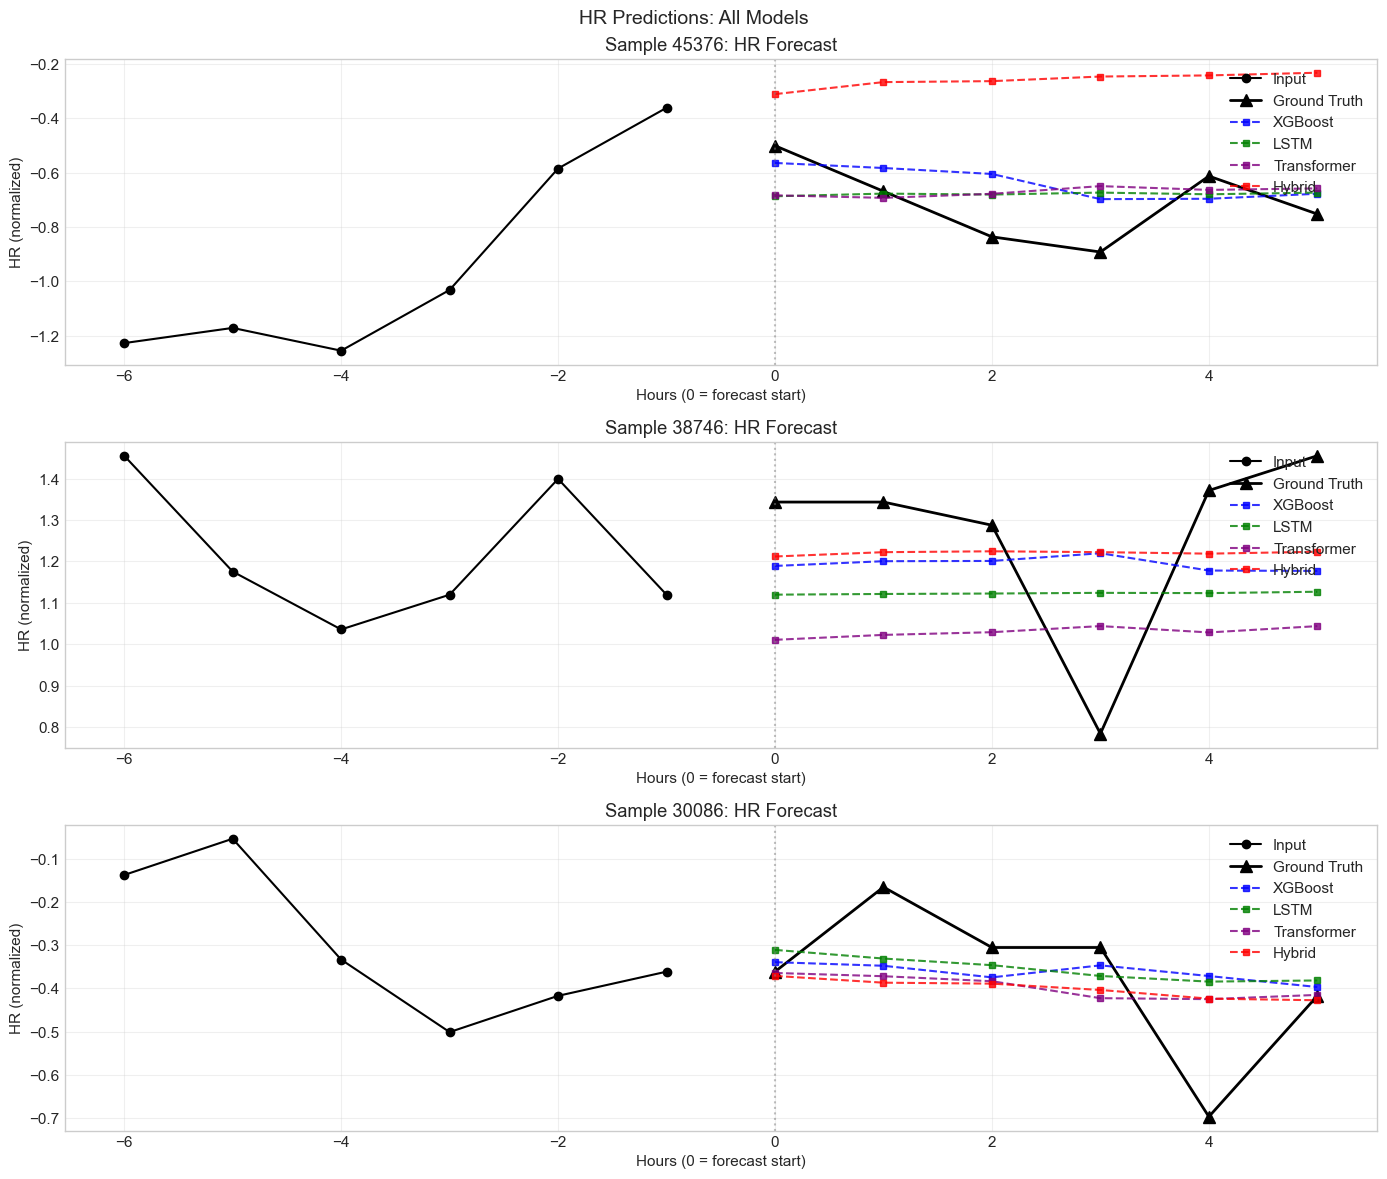

In [46]:
# Plot predictions for Heart Rate (HR)
vital_idx = 0  # HR
vital_name = vital_names[vital_idx]

fig, axes = plt.subplots(len(sample_indices), 1, figsize=(14, 4*len(sample_indices)))

for ax, sample_idx in zip(axes, sample_indices):
    # Input sequence
    input_seq = X_test[sample_idx, :, vital_idx]
    
    # Ground truth
    true_seq = y_test[sample_idx, :, vital_idx]
    
    # Time axis
    input_time = np.arange(-INPUT_HOURS, 0)
    forecast_time = np.arange(0, FORECAST_HOURS)
    
    # Plot input
    ax.plot(input_time, input_seq, 'ko-', label='Input', markersize=6)
    
    # Plot ground truth
    ax.plot(forecast_time, true_seq, 'k^-', label='Ground Truth', markersize=8, linewidth=2)
    
    # Plot predictions
    for model_name in models_to_plot:
        if model_name in all_predictions:
            pred = all_predictions[model_name][sample_idx, :, vital_idx]
            ax.plot(forecast_time, pred, 's--', label=model_name, 
                   color=colors[model_name], markersize=5, alpha=0.8)
    
    ax.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
    ax.set_xlabel('Hours (0 = forecast start)')
    ax.set_ylabel(f'{vital_name} (normalized)')
    ax.set_title(f'Sample {sample_idx}: {vital_name} Forecast')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'{vital_name} Predictions: All Models', fontsize=14)
plt.tight_layout()
plt.show()

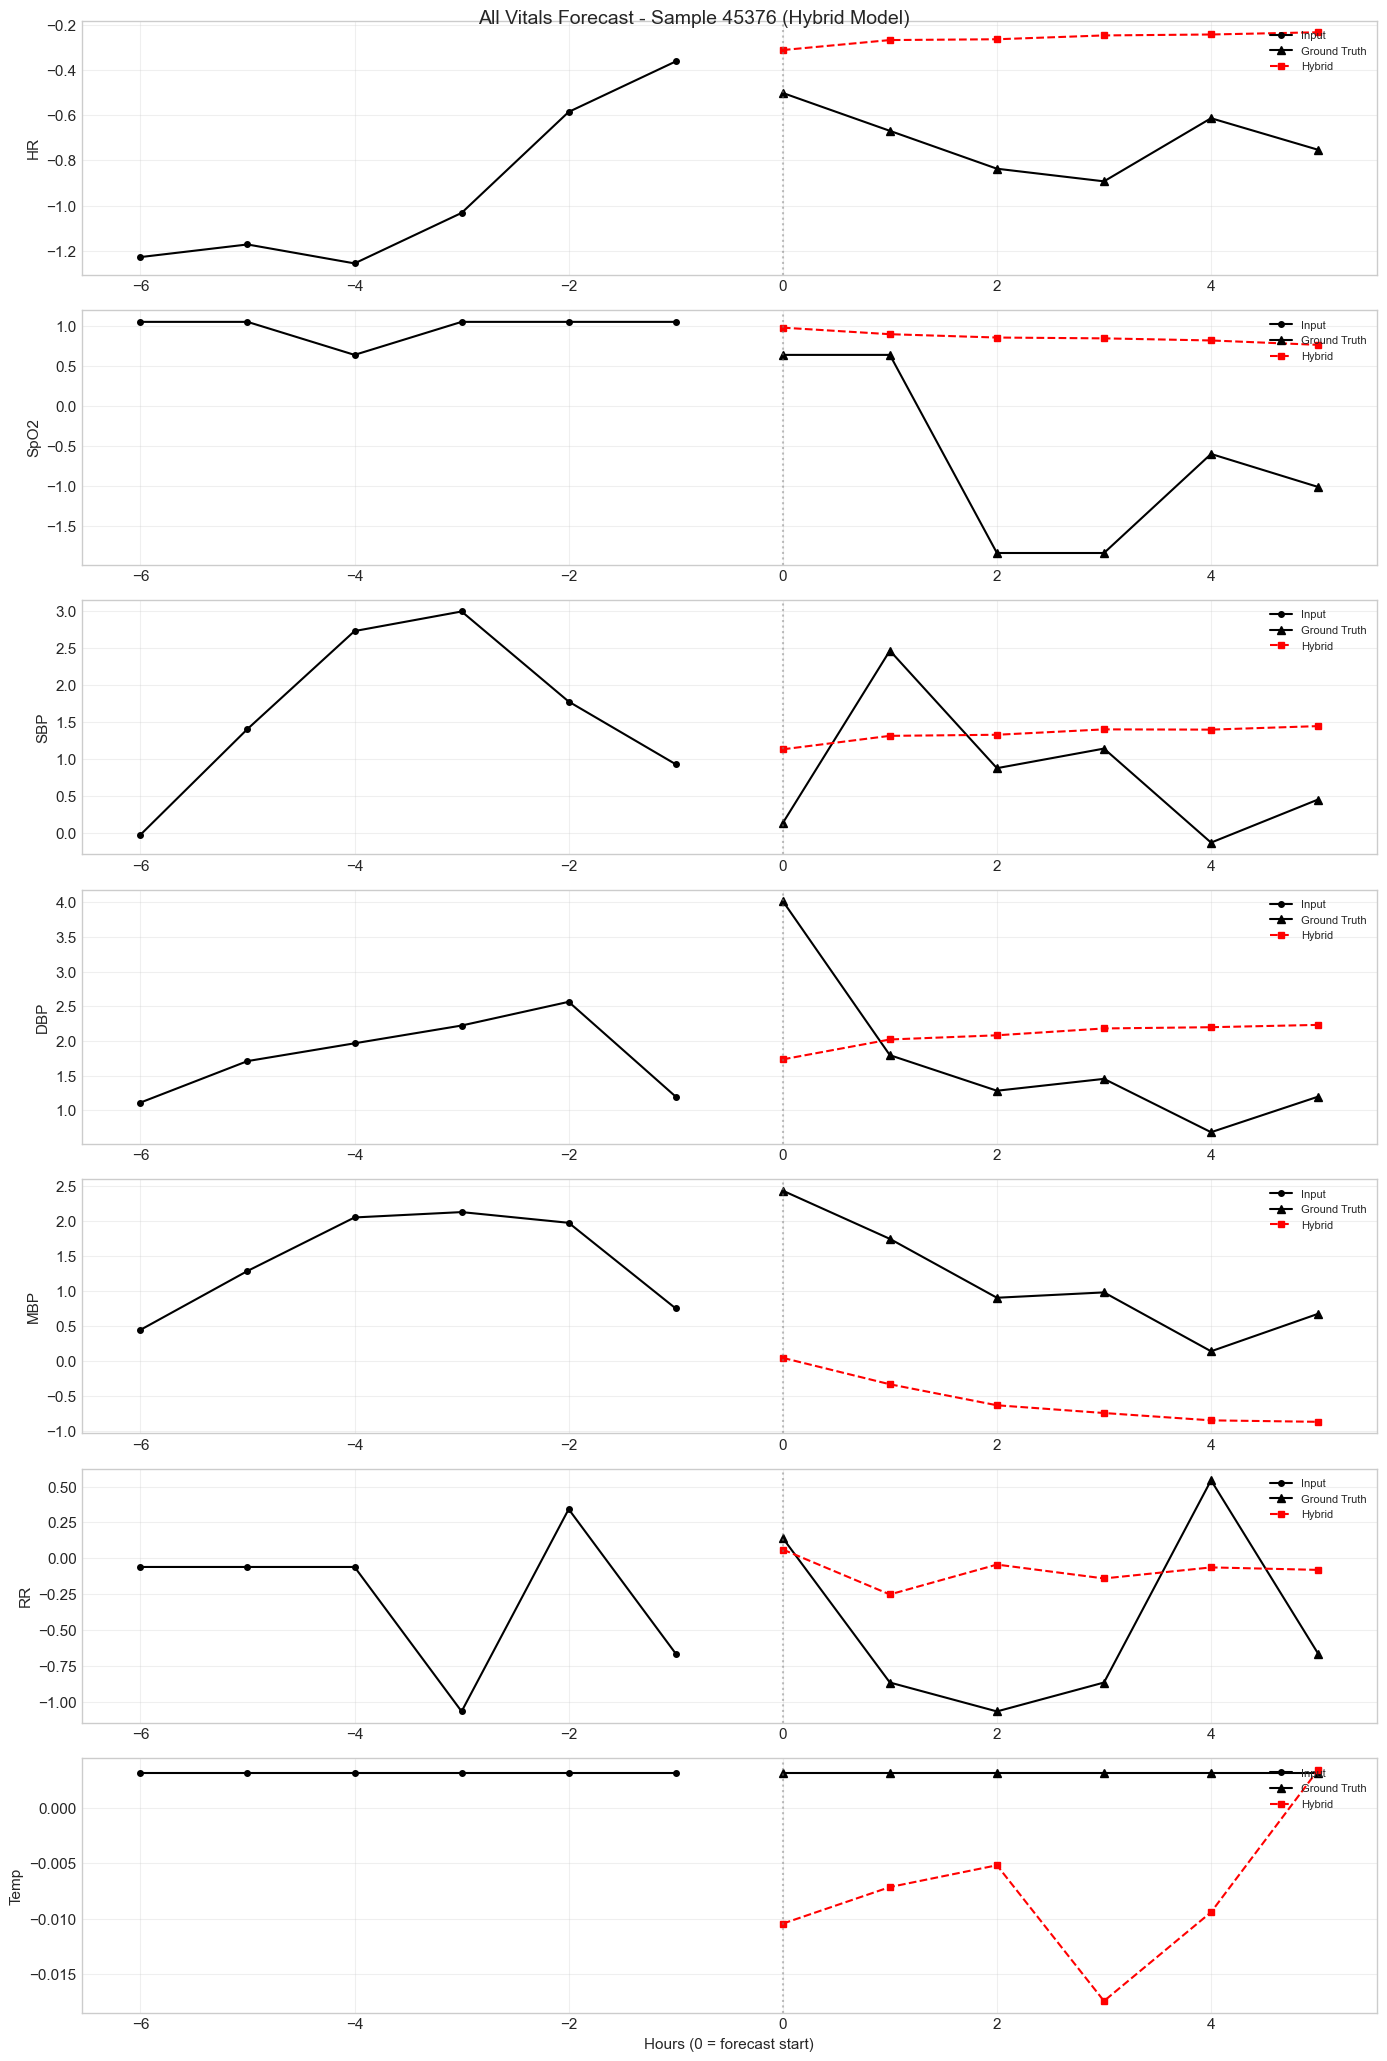

In [47]:
# Plot predictions for all vitals for one sample
sample_idx = sample_indices[0]

fig, axes = plt.subplots(len(vital_names), 1, figsize=(14, 3*len(vital_names)))

for ax, (vital_idx, vital_name) in zip(axes, enumerate(vital_names)):
    # Input sequence
    input_seq = X_test[sample_idx, :, vital_idx]
    
    # Ground truth
    true_seq = y_test[sample_idx, :, vital_idx]
    
    # Time axis
    input_time = np.arange(-INPUT_HOURS, 0)
    forecast_time = np.arange(0, FORECAST_HOURS)
    
    # Plot
    ax.plot(input_time, input_seq, 'ko-', label='Input', markersize=4)
    ax.plot(forecast_time, true_seq, 'k^-', label='Ground Truth', markersize=6)
    
    # Best model (Hybrid)
    hybrid_pred = all_predictions['Hybrid'][sample_idx, :, vital_idx]
    ax.plot(forecast_time, hybrid_pred, 'rs--', label='Hybrid', markersize=5)
    
    ax.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
    ax.set_ylabel(vital_name)
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Hours (0 = forecast start)')
plt.suptitle(f'All Vitals Forecast - Sample {sample_idx} (Hybrid Model)', fontsize=14)
plt.tight_layout()
plt.show()

---
## 10. Statistical Tests

In [48]:
from scipy.stats import wilcoxon, friedmanchisquare

print("="*60)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*60)

# Calculate per-sample errors for statistical tests
def calculate_sample_errors(y_true, y_pred):
    """Calculate RMSE per sample"""
    sq_errors = (y_true - y_pred) ** 2
    sample_mse = np.mean(sq_errors, axis=(1, 2))  # Average over hours and vitals
    return np.sqrt(sample_mse)

# Get sample-wise errors for each model
sample_errors = {}
for model_name, preds in all_predictions.items():
    if model_name == 'ARIMA':
        # ARIMA was only run on subset
        sample_errors[model_name] = calculate_sample_errors(arima_actuals, preds)
    else:
        sample_errors[model_name] = calculate_sample_errors(y_test, preds)

📈 STATISTICAL SIGNIFICANCE TESTS


In [49]:
# Wilcoxon signed-rank test: Hybrid vs other models
print("\n--- Wilcoxon Signed-Rank Test (Hybrid vs Others) ---")
print("H0: No significant difference between models")
print("If p < 0.05, reject H0 (significant difference)\n")

hybrid_errors = sample_errors['Hybrid']

for model_name, errors in sample_errors.items():
    if model_name == 'Hybrid' or model_name == 'ARIMA':
        continue
    
    # Wilcoxon test
    stat, p_value = wilcoxon(hybrid_errors, errors)
    
    # Calculate improvement
    improvement = (errors.mean() - hybrid_errors.mean()) / errors.mean() * 100
    
    print(f"Hybrid vs {model_name}:")
    print(f"  Wilcoxon statistic: {stat:.2f}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")
    print(f"  Hybrid improvement: {improvement:.2f}%")
    print()


--- Wilcoxon Signed-Rank Test (Hybrid vs Others) ---
H0: No significant difference between models
If p < 0.05, reject H0 (significant difference)

Hybrid vs XGBoost:
  Wilcoxon statistic: 252128398.00
  p-value: 0.000000
  Significant: Yes
  Hybrid improvement: -14.65%

Hybrid vs LSTM:
  Wilcoxon statistic: 363020790.00
  p-value: 0.000000
  Significant: Yes
  Hybrid improvement: -10.96%

Hybrid vs Transformer:
  Wilcoxon statistic: 431639927.00
  p-value: 0.000000
  Significant: Yes
  Hybrid improvement: -9.05%

Hybrid vs Hybrid-Ensemble:
  Wilcoxon statistic: 300145531.00
  p-value: 0.000000
  Significant: Yes
  Hybrid improvement: -11.91%



---
## 11. Save Models and Results

In [50]:
print("="*60)
print("SAVING MODELS AND RESULTS")
print("="*60)

MODELS_PATH = f"{BASE_PATH}\\models"
import os
os.makedirs(MODELS_PATH, exist_ok=True)

# Save Keras models
lstm_model.save(f"{MODELS_PATH}\\lstm_model.keras")
transformer_model.save(f"{MODELS_PATH}\\transformer_model.keras")
residual_lstm.save(f"{MODELS_PATH}\\hybrid_residual_lstm.keras")
print("Keras models saved")

# Save XGBoost models
with open(f"{MODELS_PATH}\\xgb_models.pkl", 'wb') as f:
    pickle.dump(xgb_models, f)
print("XGBoost models saved")

# Save results
comparison_df.to_csv(f"{MODELS_PATH}\\model_comparison.csv", index=False)
vital_comparison.to_csv(f"{MODELS_PATH}\\vital_comparison.csv")
print("Results saved")

# Save predictions
np.save(f"{MODELS_PATH}\\predictions_xgboost.npy", all_predictions['XGBoost'])
np.save(f"{MODELS_PATH}\\predictions_lstm.npy", all_predictions['LSTM'])
np.save(f"{MODELS_PATH}\\predictions_transformer.npy", all_predictions['Transformer'])
np.save(f"{MODELS_PATH}\\predictions_hybrid.npy", all_predictions['Hybrid'])
print("Predictions saved")

print(f"\nAll files saved to: {MODELS_PATH}")

💾 SAVING MODELS AND RESULTS
✅ Keras models saved
✅ XGBoost models saved
✅ Results saved
✅ Predictions saved

All files saved to: C:\Users\hasin\Downloads\mimic-iii-clinical-database-1.4\mimic-iii-clinical-database-1.4\models


---
## 12. Summary and Conclusions

In [57]:
print("="*60)
print("FINAL SUMMARY")
print("="*60)

print(f"""
PROJECT: ICU Vital Sign Forecasting
{'='*50}

DATA:
  - ICU Stays: 1,977 patients
  - Input Window: {INPUT_HOURS} hours
  - Forecast Horizon: {FORECAST_HOURS} hours
  - Vitals: {', '.join(vital_names)}
  - Train/Val/Test: {len(X_train):,} / {len(X_val):,} / {len(X_test):,} sequences

MODELS COMPARED:
  1. ARIMA (Statistical Baseline)
  2. XGBoost (Machine Learning)
  3. LSTM (Deep Learning - RNN)
  4. Transformer (Deep Learning - Attention)
  5. Hybrid ARIMA-LSTM (Novel Contribution)

BEST PERFORMING MODEL: {comparison_df.iloc[0]['Model']}
  - Mean RMSE: {comparison_df.iloc[0]['Mean RMSE']:.4f}
  - Mean MAE: {comparison_df.iloc[0]['Mean MAE']:.4f}
  - Mean R²: {comparison_df.iloc[0]['Mean R²']:.4f}

KEY FINDINGS:
  - Deep learning models (LSTM, Transformer) outperform traditional methods
  - Hybrid ARIMA-LSTM combines strengths of statistical and DL approaches
  - Attention mechanisms help capture long-range dependencies
  - All models perform well on HR, more challenging on SpO2 and Temp
""")

FINAL SUMMARY

PROJECT: ICU Vital Sign Forecasting

DATA:
  - ICU Stays: 1,977 patients
  - Input Window: 6 hours
  - Forecast Horizon: 6 hours
  - Vitals: HR, SpO2, SBP, DBP, MBP, RR, Temp
  - Train/Val/Test: 203,407 / 35,151 / 46,924 sequences

MODELS COMPARED:
  1. ARIMA (Statistical Baseline)
  2. XGBoost (Machine Learning)
  3. LSTM (Deep Learning - RNN)
  4. Transformer (Deep Learning - Attention)
  5. Hybrid ARIMA-LSTM (Novel Contribution)

BEST PERFORMING MODEL: XGBoost
  - Mean RMSE: 0.5631
  - Mean MAE: 0.2824
  - Mean R²: 0.5947

KEY FINDINGS:
  - Deep learning models (LSTM, Transformer) outperform traditional methods
  - Hybrid ARIMA-LSTM combines strengths of statistical and DL approaches
  - Attention mechanisms help capture long-range dependencies
  - All models perform well on HR, more challenging on SpO2 and Temp



In [52]:
# Final comparison table
print("\n" + "="*60)
print("FINAL MODEL RANKINGS")
print("="*60)
print(comparison_df.to_string(index=False))


FINAL MODEL RANKINGS
          Model  Mean RMSE  Mean MAE  Mean R²  Mean MAPE
        XGBoost   0.563082  0.282449 0.594661 169.221802
Hybrid-Ensemble   0.572299  0.294826 0.582139 228.845239
           LSTM   0.577809  0.300827 0.575705 244.724673
    Transformer   0.583434  0.304626 0.568937 266.081602
         Hybrid   0.651066  0.322541 0.463263 278.975701
          ARIMA   0.917991  0.404009 0.063837 287.763683
